<h1>ML Random Forest Example</h1>
This example demonstrates classification of time-series data from the force-torque sensor to detect grasping failure. The data is taken from the <a href="https://archive.ics.uci.edu/ml/datasets/Robot+Execution+Failures">Robot execution failures</a> dataset. It consists of 87 labeled instances of sequences of 15 F/T measurements and class labels.

The data is parsed into a pandas dataframe, broken into training and test set, and run through a random forest regressor from sklearn. 

<br>
This example has been adapted from the very <a href="https://towardsdatascience.com/random-forest-in-python-24d0893d51c0">nice introduction</a> to Random Forest regression by William Koehrsen.


In [1]:
# Import data processing tools
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib ipympl

import numpy as np

# Import ML tools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Import tools needed for visualization
from IPython.display import Image, display
from sklearn.tree import export_graphviz
import pydot

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


The dataset consists of time series of 6-DoF force/torque measurements that are labeled with success ('normal') or failure ('obstruction', 'collision', 'fr_collision'). The raw data can be inspected <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/robotfailure-mld/lp1.data">here</a> and needs to be converted in table format. <br><br>
The code for parsing the data has been adopted from a <a href="https://tsfresh.readthedocs.io/en/latest/_modules/tsfresh/examples/robot_execution_failures.html">tsfresh tutorial</a>. It proceeds by reading the data file line by line and storing an entire time series in a single row. Sucess and the various failure modes are coded as a boolean value. 

In [2]:
    id_to_target = {}
    df_rows = []
    df_block = []

    with open('data/lp1.data') as f:
        cur_id = 0
        time = 0

        for line in f.readlines():
            # New sample --> increase id, reset time and determine target
            if line[0] not in ['\t', '\n']:               
                time = 0
                #id_to_target[cur_id] = line.strip()
                id_to_target[cur_id] = (line.strip()=='normal')
                if(df_block): 
                    df_rows.append(np.array(df_block).reshape(1,90)[0].tolist())
                df_block = []
                cur_id += 1
            # Data row --> split and convert values, create complete df row
            elif line[0] == '\t':
                values = list(map(int, line.split('\t')[1:]))
                #df_rows.append([cur_id, time] + values)
                df_block.append(values)
                time += 1
        df_rows.append(np.array(df_block).reshape(1,90)[0].tolist())

    columns=[]
    for i in range(0,15):
        columns=columns+['F_x'+str(i), 'F_y'+str(i), 'F_z'+str(i), 'T_x'+str(i), 'T_y'+str(i), 'T_z'+str(i)]
    
    df = pd.DataFrame(df_rows, columns=columns) # Store all data in a Pandas dataframe
    y = pd.Series(id_to_target) # Store all class labels in a Pandas series

In [3]:
df.tail()

,F_x0,F_y0,F_z0,T_x0,T_y0,T_z0,F_x1,F_y1,F_z1,T_x1,...,F_z13,T_x13,T_y13,T_z13,F_x14,F_y14,F_z14,T_x14,T_y14,T_z14
83,-29,-10,-208,180,12,-11,-29,-4,-246,192,...,-918,396,101,-23,-105,63,-912,394,100,-25
84,4,6,50,-25,1,0,4,8,44,-26,...,4,-46,14,-7,19,14,2,-42,10,-7
85,21,15,-14,-46,16,-7,23,18,-27,-49,...,-346,-88,154,4,148,69,-411,-95,191,8
86,171,86,-486,-113,222,13,198,96,-566,-125,...,-1036,-118,466,44,342,154,-1036,-118,466,44
87,-6,3,52,-15,-17,3,-7,2,52,-17,...,26,-29,-27,5,-13,2,15,-25,-25,6


In [4]:
y.head()

0    True
1    True
2    True
3    True
4    True
dtype: bool

We are using sklearn's RandomForestRegressor using standard parameters. 75% of the data is used for training and 25% as test set.

In [5]:
labels=y
features=np.array(df)
feature_list=list(df.columns)

In [6]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

In [7]:
rf = RandomForestRegressor(n_estimators = 100, max_depth =15, random_state =42)

In [8]:
rf.fit(train_features,train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [9]:
predictions = np.round(rf.predict(test_features))

<h2>Results</h2>
We can now compare the predictions made by the random forest with the known labels from the test set and calculate the percentage of errorneous predictions. 

In [10]:
errors = abs(predictions-test_labels)

In [11]:
print('Error: ',sum(errors)/len(test_labels)*100,'%')

Error:  9.090909090909092 %


<h1>Using machine learning for system analysis</h1>

A byproduct of the training process are statistical measures how predictive the different attributes of the
problem set are. The code below retrieves this information from the classifier and sorts them after their importance.
<br><br>
This information can be used to train classifiers that are computationally more efficient or to better understand what is actually 
going on in the robotic system. In this example, we learn that force measurements in z-direction are most predictive to distinguish a failed from a normal grasp.


In [12]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: F_z11                Importance: 0.32
Variable: F_z0                 Importance: 0.1
Variable: F_z1                 Importance: 0.09
Variable: F_z2                 Importance: 0.04
Variable: F_z6                 Importance: 0.03
Variable: T_x8                 Importance: 0.03
Variable: F_x1                 Importance: 0.02
Variable: F_z4                 Importance: 0.02
Variable: F_x7                 Importance: 0.02
Variable: F_z9                 Importance: 0.02
Variable: F_y0                 Importance: 0.01
Variable: T_x0                 Importance: 0.01
Variable: T_y0                 Importance: 0.01
Variable: F_y1                 Importance: 0.01
Variable: T_x1                 Importance: 0.01
Variable: T_y1                 Importance: 0.01
Variable: F_y2                 Importance: 0.01
Variable: T_x2                 Importance: 0.01
Variable: F_z3                 Importance: 0.01
Variable: F_x5                 Importance: 0.01
Variable: T_x5                 Importance

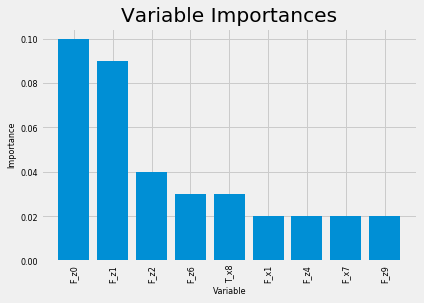

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.bar(range(1,10),[a[1] for a in feature_importances[1:10]])
plt.xticks(range(1,10), [a[0] for a in feature_importances[1:10]], rotation='vertical',fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Importance',fontsize=8); plt.xlabel('Variable',fontsize=8); plt.title('Variable Importances');
plt.show();
